<a href="https://colab.research.google.com/github/SigmaGQ/InsDetek/blob/main/InsDetek_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Setting

In [ ]:
import os
from google.colab import drive
# mount Google drive
drive.mount('/content/drive')


# by default everything gets executed and saved in 'Berkeley Capstone (Students)'
# notebook_path = '/content/drive/MyDrive/Berkeley Capstone (Students)/Code' # WK
notebook_path = '/content/drive/MyDrive/Capstone/Berkeley Capstone (Students)/Code' # GQ
os.chdir(notebook_path)

!echo -e "\nCurrent directory:"
!pwd

Mounted at /content/drive

Current directory:
/content/drive/.shortcut-targets-by-id/1yBERxWlYaZqd2aPZEzBr21t8G6McvwZA/Berkeley Capstone (Students)/Code


# Data Loading

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

## By Week

In [ ]:
week_df = pd.read_csv('./ExtractedData/weekr4.2.csv')
week_df.head()

,starttime,endtime,user,week,role,b_unit,f_unit,dept,team,ITAdmin,O,C,E,A,N,n_allact,allact_n-pc0,allact_n-pc1,allact_n-pc2,allact_n-pc3,n_workhourallact,workhourallact_n-pc0,workhourallact_n-pc1,workhourallact_n-pc2,workhourallact_n-pc3,n_afterhourallact,afterhourallact_n-pc0,afterhourallact_n-pc1,afterhourallact_n-pc2,afterhourallact_n-pc3,n_weekendallact,weekendallact_n-pc0,weekendallact_n-pc1,weekendallact_n-pc2,weekendallact_n-pc3,n_logon,logon_n-pc0,logon_n-pc1,logon_n-pc2,logon_n-pc3,...,weekendhttp_socnetf_n-pc1,weekendhttp_socnetf_n-pc2,weekendhttp_socnetf_n-pc3,weekendhttp_n_cloudf,weekendhttp_cloudf_mean_url_len,weekendhttp_cloudf_mean_url_depth,weekendhttp_cloudf_mean_http_c_len,weekendhttp_cloudf_mean_http_c_nwords,weekendhttp_cloudf_n-pc0,weekendhttp_cloudf_n-pc1,weekendhttp_cloudf_n-pc2,weekendhttp_cloudf_n-pc3,weekendhttp_n_jobf,weekendhttp_jobf_mean_url_len,weekendhttp_jobf_mean_url_depth,weekendhttp_jobf_mean_http_c_len,weekendhttp_jobf_mean_http_c_nwords,weekendhttp_jobf_n-pc0,weekendhttp_jobf_n-pc1,weekendhttp_jobf_n-pc2,weekendhttp_jobf_n-pc3,weekendhttp_n_leakf,weekendhttp_leakf_mean_url_len,weekendhttp_leakf_mean_url_depth,weekendhttp_leakf_mean_http_c_len,weekendhttp_leakf_mean_http_c_nwords,weekendhttp_leakf_n-pc0,weekendhttp_leakf_n-pc1,weekendhttp_leakf_n-pc2,weekendhttp_leakf_n-pc3,weekendhttp_n_hackf,weekendhttp_hackf_mean_url_len,weekendhttp_hackf_mean_url_depth,weekendhttp_hackf_mean_http_c_len,weekendhttp_hackf_mean_http_c_nwords,weekendhttp_hackf_n-pc0,weekendhttp_hackf_n-pc1,weekendhttp_hackf_n-pc2,weekendhttp_hackf_n-pc3,insider
0,1.262506e+09,1.263110e+09,0,1,6,0,1,11,20,0,40,39,36,19,40,533,533,0,0,0,475,475,0,0,0,58,58,0,0,0,0,0,0,0,0,9,9,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.262506e+09,1.263110e+09,1,1,32,0,4,10,19,0,26,22,17,39,32,895,895,0,0,0,893,893,0,0,0,2,2,0,0,0,0,0,0,0,0,6,6,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.262506e+09,1.263110e+09,2,1,35,0,1,11,20,0,22,16,23,40,33,603,603,0,0,0,559,559,0,0,0,44,44,0,0,0,0,0,0,0,0,9,9,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.262506e+09,1.263110e+09,3,1,30,0,2,12,14,0,40,48,36,14,37,65,65,0,0,0,53,53,0,0,0,12,12,0,0,0,0,0,0,0,0,5,5,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.262506e+09,1.263110e+09,4,1,30,0,2,12,33,0,36,44,23,44,25,64,64,0,0,0,57,57,0,0,0,7,7,0,0,0,0,0,0,0,0,5,5,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
week_df.loc[:,'starttime'] = pd.to_datetime(week_df['starttime'])
week_df.loc[:,'endtime'] = pd.to_datetime(week_df['endtime'])
week_df.head()

,starttime,endtime,user,week,role,b_unit,f_unit,dept,team,ITAdmin,O,C,E,A,N,n_allact,allact_n-pc0,allact_n-pc1,allact_n-pc2,allact_n-pc3,n_workhourallact,workhourallact_n-pc0,workhourallact_n-pc1,workhourallact_n-pc2,workhourallact_n-pc3,n_afterhourallact,afterhourallact_n-pc0,afterhourallact_n-pc1,afterhourallact_n-pc2,afterhourallact_n-pc3,n_weekendallact,weekendallact_n-pc0,weekendallact_n-pc1,weekendallact_n-pc2,weekendallact_n-pc3,n_logon,logon_n-pc0,logon_n-pc1,logon_n-pc2,logon_n-pc3,...,weekendhttp_socnetf_n-pc1,weekendhttp_socnetf_n-pc2,weekendhttp_socnetf_n-pc3,weekendhttp_n_cloudf,weekendhttp_cloudf_mean_url_len,weekendhttp_cloudf_mean_url_depth,weekendhttp_cloudf_mean_http_c_len,weekendhttp_cloudf_mean_http_c_nwords,weekendhttp_cloudf_n-pc0,weekendhttp_cloudf_n-pc1,weekendhttp_cloudf_n-pc2,weekendhttp_cloudf_n-pc3,weekendhttp_n_jobf,weekendhttp_jobf_mean_url_len,weekendhttp_jobf_mean_url_depth,weekendhttp_jobf_mean_http_c_len,weekendhttp_jobf_mean_http_c_nwords,weekendhttp_jobf_n-pc0,weekendhttp_jobf_n-pc1,weekendhttp_jobf_n-pc2,weekendhttp_jobf_n-pc3,weekendhttp_n_leakf,weekendhttp_leakf_mean_url_len,weekendhttp_leakf_mean_url_depth,weekendhttp_leakf_mean_http_c_len,weekendhttp_leakf_mean_http_c_nwords,weekendhttp_leakf_n-pc0,weekendhttp_leakf_n-pc1,weekendhttp_leakf_n-pc2,weekendhttp_leakf_n-pc3,weekendhttp_n_hackf,weekendhttp_hackf_mean_url_len,weekendhttp_hackf_mean_url_depth,weekendhttp_hackf_mean_http_c_len,weekendhttp_hackf_mean_http_c_nwords,weekendhttp_hackf_n-pc0,weekendhttp_hackf_n-pc1,weekendhttp_hackf_n-pc2,weekendhttp_hackf_n-pc3,insider
0,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,0,1,6,0,1,11,20,0,40,39,36,19,40,533,533,0,0,0,475,475,0,0,0,58,58,0,0,0,0,0,0,0,0,9,9,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,1,1,32,0,4,10,19,0,26,22,17,39,32,895,895,0,0,0,893,893,0,0,0,2,2,0,0,0,0,0,0,0,0,6,6,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,2,1,35,0,1,11,20,0,22,16,23,40,33,603,603,0,0,0,559,559,0,0,0,44,44,0,0,0,0,0,0,0,0,9,9,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,3,1,30,0,2,12,14,0,40,48,36,14,37,65,65,0,0,0,53,53,0,0,0,12,12,0,0,0,0,0,0,0,0,5,5,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1970-01-01 00:00:01.262505600,1970-01-01 00:00:01.263110400,4,1,30,0,2,12,33,0,36,44,23,44,25,64,64,0,0,0,57,57,0,0,0,7,7,0,0,0,0,0,0,0,0,5,5,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### By user

## By Day

In [ ]:
day_df = pd.read_csv('./ExtractedData/dayr4.2.csv')

# Data Processing

## Get Temporal Information

In [ ]:
from scipy import stats 

def get_features(df, removed_cols):
    x_cols = [i for i in df.columns if i not in removed_cols]
    return x_cols

def get_temporal_info(df, x_cols, level="week", window=4, method='Percentile'):
    output = pd.DataFrame(columns=[level, 'user','insider']+x_cols)

    for t in trange(window+1, df[level].max()+1):
      X = df[df[level].isin([w for w in range(t-window, t)])]
      x_t = df[df[level]==t]
      user_list = set(X.user.tolist()).intersection(set(x_t.user.tolist()))

      for user in user_list:
        X_u = X[X.user == user]
        xt_u = x_t[x_t.user == user]
        xt_output = [t, user, xt_u.insider.values[0]]

        if method == 'Percentile':
            for feature in x_cols:
              pct = stats.percentileofscore(X_u[feature].values, xt_u[feature].values)
              xt_output.append(pct)
        else:
            xt_u_list = xt_u.reset_index().loc[0, x_cols].tolist()
            if method == 'Median Difference':
                X_u_list = X_u.groupby("user").median().reset_index().loc[0, x_cols].tolist()
                diff = list(map(lambda x: x[0]-x[1], zip(xt_u_list, X_u_list))) 
            elif method == 'Mean Difference':
                X_u_list = X_u.groupby("user").mean().reset_index().loc[0, x_cols].tolist()
                diff = list(map(lambda x: x[0]-x[1], zip(xt_u_list, X_u_list))) 
            xt_output = xt_output + diff

        output = output.append(dict(zip(output.columns,xt_output)), ignore_index=True)
    
    return output

## Split Dataset

In [ ]:
def split_dataset(data, x_cols):
  
    data1stHalf = data[data.week <= max(data.week)/2]
    dataTest = data[data.week > max(data.week)/2]

    selectedTrainUsers =  set(data1stHalf[data1stHalf.insider > 0]['user'])
    nUsers = np.random.permutation(list(set(data1stHalf.user) - selectedTrainUsers))
    trainUsers = np.concatenate((list(selectedTrainUsers), nUsers[:200-len(selectedTrainUsers)]))

    unKnownTestUsers = list(set(dataTest.user) - selectedTrainUsers)
    
    xTrain = data1stHalf[data1stHalf.user.isin(trainUsers)][x_cols].values
    yTrain = data1stHalf[data1stHalf.user.isin(trainUsers)]['insider'].values
    yTrainBin = yTrain > 0
    # Wenqi: Test dataset not the validation dataset
    xTest = dataTest[dataTest.user.isin(unKnownTestUsers)][x_cols].values
    yTest = dataTest[dataTest.user.isin(unKnownTestUsers)]['insider'].values
    yTestBin = yTest > 0

    X = np.concatenate((xTrain, xTest))
    yBin = np.concatenate((yTrainBin, yTestBin))
    
    return X, yBin, xTrain, yTrainBin, xTest, yTestBin

In [ ]:
# window = 4
# method = 'Percentile' #['Percentile', 'Mean Difference', 'Median Difference']
# removed_cols = ['user','day','week','starttime','endtime','sessionid','insider']

# feature_names = get_features(week_df, removed_cols)
# temp_info_df = get_temporal_info(week_df, feature_names, level="week", window=window, method=method)
# X, yBin, xTrain, yTrainBin, xTest, yTestBin = split_dataset(temp_info_df, feature_names)

In [ ]:
# temp_info_df.to_csv('Percentile.csv', index = False)

removed_cols = ['user','day','week','starttime','endtime','sessionid','insider']
feature_names = get_features(week_df, removed_cols)
# temp_info_df = pd.read_csv('Percentile.csv')
X, yBin, xTrain, yTrainBin, xTest, yTestBin = split_dataset(week_df, feature_names)

# Score

In [ ]:
from sklearn.metrics import roc_curve, auc, recall_score
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
def acu_curve(y, prob):
    
    fpr, tpr, threshold = roc_curve(y, prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, 
             tpr, 
             color = 'darkorange',
             lw = 2, 
             label = 'ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = "lower right")
    plt.show()

# Model

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def RandomForestModel(verbose=1):

    param_rf = {'n_estimators': [100, 200, 300, 500],
                'max_depth': [4, 6, 8, 10]}

    return RandomForestClassifier(), param_rf

## XGBoost

In [ ]:
import xgboost as xgb

def XGBoostModel():

    param_xgb = {'max_depth': [4, 6, 8, 10],
                 'n_estimators': [100, 200, 300, 400, 500],
                 'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
                 'subsample': [0.3, 0.5, 0.7, 0.9]}

    return xgb.XGBClassifier(booster='gbtree', scale_pos_weight=15, eval_metric='auc'), param_xgb

## LSTM

### Step 1 Data Processing

In [ ]:
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pack_sequence,pad_packed_sequence
from collections import defaultdict
import torch
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

df_dic = defaultdict(pd.DataFrame)
for user in week_df.user.unique():
  df_dic[user] = week_df[week_df.user == user]


sequence = []


for user, df in df_dic.items():
  input_sub = torch.tensor(df.values)
  sequence.append(input_sub)
  # input = torch.cat((input, input_sub),0)



# padded_df = pad_sequence(sequence, batch_first=True)
# packed_padded_df = pack_padded_sequence(padded_df, seq_len, batch_first=True, enforce_sorted=False)
# assert packed_padded_df[0].size() == week_df.shape)


class MyData(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn(data):
    data.sort(key=lambda x: len(x), reverse=True)
    seq_len = [s.size(0) for s in data]
    padded_df = pad_sequence(data, batch_first=True, padding_value=0)
    packed_padded_df = pack_padded_sequence(padded_df, seq_len, batch_first=True)
    return packed_padded_df

# a = torch.tensor([1,2,3,4])
# b = torch.tensor([5,6,7])
# c = torch.tensor([7,8])
# d = torch.tensor([9])
# train_x = [a, b, c, d]
train_x = sequence

data = MyData(train_x)
# data = Dataset()
data_loader = DataLoader(data, batch_size=20, shuffle=True, collate_fn=collate_fn)
# 采用默认的 collate_fn 会报错
#data_loader = DataLoader(data, batch_size=2, shuffle=True) 
batch_x = iter(data_loader).next()
print(len(data_loader))

50


In [ ]:
pad_packed_sequence(batch_x, batch_first=True)[0].shape

torch.Size([20, 72, 668])

### lstm-predict GQ

In [ ]:
# import torch
# from torch import nn
# import torch.nn.functional as F

# if torch.cuda.is_available():
#     print('Found GPU')
# else:
#     print('Did not find GPU')
# device = 'gpu'

Did not find GPU


In [ ]:
import torch

# input_size = len(feature_names)      # 输入的维度，就是我们word_embedding的长度128
input_size = 1      # 输入的维度，就是我们word_embedding的长度128

hidden_size = 64      # 隐层状态的维数：（每个LSTM单元或者时间步的输出的ht的维度，单元内部有权重与偏差计算）
num_layers = 1 # RNN层的个数：（在竖直方向堆叠的多个相同个数单元的层数）
seq_len = 984 # 序列长度（100天！！！！）
batch_size = 4 # 一次喂几个users

lstm = torch.nn.LSTM(input_size, hidden_size, num_layers)
# assert input.shape = [seq_len, batch_size, input_size]      # 函数没定义，就是从data中取batch条数据，input的shape：[seq_len, batch_size, input_size]=[MAX_LEN+2, batch, 128]
output, hidden = lstm(input)      # Pytorch的LSTM会自己初始化hidden，因此hidden不写一样

output1 = output[-1]      # 取最后一层的输出作为最终输出，因为只有一层LSTM，output[-1]==output[0]
print(output.shape)
# RETURN: [seq_len, batch_size, hidden_size]

torch.Size([984, 4, 64])


In [ ]:
output.shape

torch.Size([984, 4, 64])

### lstm-supervised GQ

In [ ]:
input_demo = pad_packed_sequence(batch_x, batch_first=True)[0].shape

NameError: ignored

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, tagset_size):
        super(LSTMTagger, self).__init__()
        # self.hidden_dim = hidden_dim

        # self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_size, tagset_size)

    def forward(self, input):
        # embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(input) 
        # assert input.shape = [seq_len, batch_size, input_size] = [72, 20, 668]
        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [ ]:
input_size = 984      # 输入的维度，就是我们word_embedding的长度128
hidden_size = 64      # 隐层状态的维数：（每个LSTM单元或者时间步的输出的ht的维度，单元内部有权重与偏差计算）
num_layers = 1 # RNN层的个数：（在竖直方向堆叠的多个相同个数单元的层数）
seq_len = 72 # 序列长度（100天！！！！）
batch_size = 4 # 一次喂几个users
tagset_size = 2 # 0 / 1

model = LSTMTagger(input_size, hidden_size, num_layers, tagset_size)
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    for batch in tqdm.tqdm_notebook(data_loader):
        inputs = batch
        # inputs = prepare_sequence(training_data[0][0], word_to_ix)
        tag_scores = model(inputs)
        print(tag_scores)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for batch in tqdm.tqdm_notebook(data_loader, leave=False):
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    # inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(tag_scores)

NameError: ignored

### diy lstm GQ

In [ ]:
my_array = np.array(data)
input = torch.tensor(my_array)
input = input.permute(1,0,2)
input.shape

input = input.to(torch.float32)


torch.Size([984, 4, 1])

In [ ]:
class NaiveLSTM(nn.Module):
    """Naive LSTM like nn.LSTM"""
    def __init__(self, input_size: int, hidden_size: int):
        super(NaiveLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # 输入门的权重矩阵和bias矩阵
        self.w_ii = Parameter(Tensor(hidden_size, input_size))
        self.w_hi = Parameter(Tensor(hidden_size, hidden_size))
        self.b_ii = Parameter(Tensor(hidden_size, 1))
        self.b_hi = Parameter(Tensor(hidden_size, 1))

        # 遗忘门的权重矩阵和bias矩阵
        self.w_if = Parameter(Tensor(hidden_size, input_size))
        self.w_hf = Parameter(Tensor(hidden_size, hidden_size))
        self.b_if = Parameter(Tensor(hidden_size, 1))
        self.b_hf = Parameter(Tensor(hidden_size, 1))

        # 输出门的权重矩阵和bias矩阵
        self.w_io = Parameter(Tensor(hidden_size, input_size))
        self.w_ho = Parameter(Tensor(hidden_size, hidden_size))
        self.b_io = Parameter(Tensor(hidden_size, 1))
        self.b_ho = Parameter(Tensor(hidden_size, 1))
        
        # cell的的权重矩阵和bias矩阵
        self.w_ig = Parameter(Tensor(hidden_size, input_size))
        self.w_hg = Parameter(Tensor(hidden_size, hidden_size))
        self.b_ig = Parameter(Tensor(hidden_size, 1))
        self.b_hg = Parameter(Tensor(hidden_size, 1))

        self.reset_weigths()

    def reset_weigths(self):
        """reset weights
        """
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            init.uniform_(weight, -stdv, stdv)

    def forward(self, inputs: Tensor, state: Tuple[Tensor]) \
        -> Tuple[Tensor, Tuple[Tensor, Tensor]]:
#       ->用来提示该函数返回值的数据类型
        """Forward
        Args:
            inputs: [1, 1, input_size]
            state: ([1, 1, hidden_size], [1, 1, hidden_size])
        """

#         batch_size, seq_size , _ = inputs.size()

        if state is None:
            h_t = torch.zeros(1, self.hidden_size).t()
            c_t = torch.zeros(1, self.hidden_size).t()
        else:
            (h, c) = state
            h_t = h.squeeze(0).t()
            c_t = c.squeeze(0).t()

        hidden_seq = []

        seq_size = 1
        for t in range(seq_size):
            x = inputs[:, t, :].t()
            # input gate
            i = torch.sigmoid(self.w_ii @ x + self.b_ii + self.w_hi @ h_t +
                              self.b_hi)
            # forget gate
            f = torch.sigmoid(self.w_if @ x + self.b_if + self.w_hf @ h_t +
                              self.b_hf)
            # cell
            g = torch.tanh(self.w_ig @ x + self.b_ig + self.w_hg @ h_t
                           + self.b_hg)
            # output gate
            o = torch.sigmoid(self.w_io @ x + self.b_io + self.w_ho @ h_t +
                              self.b_ho)
            
            c_next = f * c_t + i * g
            h_next = o * torch.tanh(c_next)
            c_next_t = c_next.t().unsqueeze(0)
            h_next_t = h_next.t().unsqueeze(0)
            hidden_seq.append(h_next_t)

        hidden_seq = torch.cat(hidden_seq, dim=0)
        return hidden_seq, (h_next_t, c_next_t)


### ?

In [ ]:
# 10：输入数据维度大小  20 ：隐状态的特征维度  2：层数，表示用来两层lstm
lstm = nn.LSTM(10, 20, 2)
# 5：序列长度 3：单个训练数据长度  10：单个序列维度  举个例子：每次运行时取3个含有5个字的句子（且句子中每个字的维度为10）
input = Variable(torch.randn(5, 3, 10))
# 2个LSTM层，batch_size=3, 隐藏层的特征维度20
h0 = Variable(torch.randn(2, 3, 20))
# 2个LSTM层，batch_size=3, 隐藏层的特征维度20
# 这里有2层lstm，output是最后一层lstm的每个词向量对应隐藏层的输出,其与层数无关，只与序列长度相关

c0 = Variable(torch.randn(2, 3, 20))
# 
# output, hn = lstm(input, (h0, c0))

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)  # 2 for bidirection 

    def forward(self, x):

        # Forward propagate RNN
        out, _ = self.lstm(x)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

rnn = RNN(input_size, hidden_size, num_layers, num_classes)
# rnn.cuda()

## Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

def IsolationForestModel():
    IF = IsolationForest(n_estimators=200, 
                         max_samples=256)
    IF.fit(xTest)
    IF_score = IF.decision_function(xTest)
    print('Detection rate at different budgets:')
    for ib in [0.001, 0.01, 0.05, 0.1, 0.2]:
        threshold = np.percentile(IF_score, 100*ib)
        flagged = np.where(IF_score<threshold)[0]
        dr = sum(yTestBin[flagged]>0)/sum(yTestBin>0)
        print(f'{100*ib}%, DR = {100*dr:.2f}%')

## AutoEncoder

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics.pairwise import paired_distances
from sklearn.preprocessing import StandardScaler

def AutoEncoderModel(xTrain):
    
    scaler = StandardScaler()
    xTrain = scaler.fit_transform(xTrain)

    l = len(feature_names)
    ae = MLPRegressor(hidden_layer_sizes = (int(l/4), int(l/8), int(l/4)),
                      activation = 'tanh',
                      max_iter = 50, 
                      random_state = 10)

    ae.fit(xTrain, xTrain)
    reconstructionError = paired_distances(xTrain, ae.predict(xTrain))
    return reconstructionError

# Unsupervised Baseline

In [ ]:
def investigation(yBin, score, budgets, ret):
    threshold = np.percentile(score, 100-100*budgets)
    flagged = np.where(score <=threshold)[0]
    yIB = yBin.copy()
    yIB[flagged] = 0
    if not ret:
        dr = sum(yIB)/sum(yBin)
        return dr
    else:
        return yIB

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


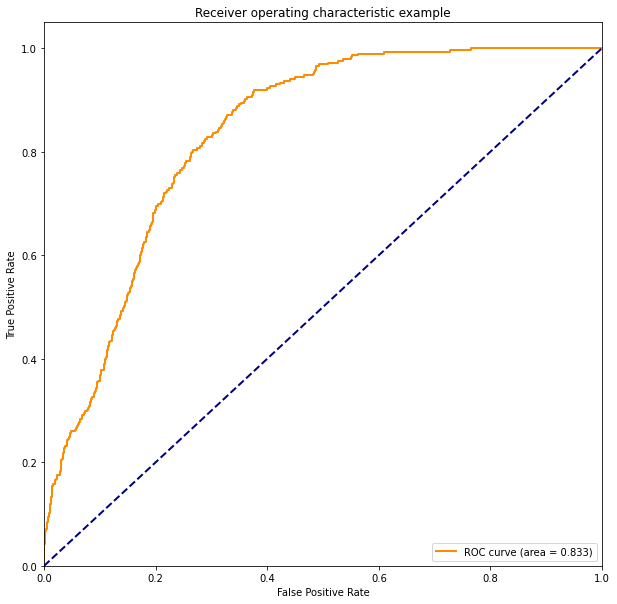

In [ ]:
AE_baseline = AutoEncoderModel(X)
acu_curve(yBin, AE_baseline)

In [ ]:
AE_baseline_dr = []
for ib in [0.001, 0.01, 0.05, 0.1]:
    dr = investigation(yBin, AE_baseline, ib, ret = False)
    AE_baseline_dr.append(dr)
    print(f'{100*ib}%, DR = {100*dr:.2f}%')
    

0.1%, DR = 4.21%
1.0%, DR = 10.18%
5.0%, DR = 25.61%
10.0%, DR = 35.79%


# Unsupervised Investigation Budget 

In [ ]:
AE_IB = AutoEncoderModel(xTrain)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


# Validation

In [ ]:
from sklearn.metrics import recall_score, classification_report, f1_score, accuracy_score
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV, TimeSeriesSplit

def ML_train(ML_model, ML_hyper, XTrain, yTrain):
    
    RS = RandomizedSearchCV(
        ML_model, 
        ML_hyper, 
        n_iter = 5,
        refit = "f1_macro",
        cv = TimeSeriesSplit(), 
        # scoring=["f1_macro", "f1_micro","roc_auc", "precision", "recall"],
        scoring = ["f1_macro", "f1_micro"],
        random_state = 0)

    RS.fit(XTrain, yTrain)

    print('Best Parameters:')
    print(RS.best_params_)

    return RS

# Testing

In [ ]:
def prediction(ML_model, xTest, yBin, yTrainIB):

    # ML model pred
    y_ML_pred = ML_model.predict(xTest)
    # Consider the first Unsupervised model part
    y_pred = np.concatenate((yTrainIB, y_ML_pred))
    report = classification_report(yBin, y_pred, output_dict=True)

    return report['True']
    # return recall_score(yBin, y_pred)

    # y_score = ML_model.predict_proba(xTest)
    # acu_curve(yTest, pd.DataFrame(y_score)[1])

In [ ]:
from collections import defaultdict

RF_pred = defaultdict(list)
XGB_pred = defaultdict(list)

for i, ib in tqdm(enumerate([0.002, 0.02, 0.1, 0.2])):
    yTrainIB = investigation(yTrainBin, AE_IB, ib, ret = True)

    RF = ML_train(RandomForestModel()[0], RandomForestModel()[1], xTrain, yTrainIB)
    XGB = ML_train(XGBoostModel()[0], XGBoostModel()[1], xTrain, yTrainIB)

    RF_metrics = prediction(RF, xTest, yBin, yTrainIB)
    XGB_metrics = prediction(XGB, xTest, yBin, yTrainIB)
    for key, values in RF_metrics.items():
      RF_pred[key].append(values)
    for key, values in XGB_metrics.items():
      XGB_pred[key].append(values)

0it [00:00, ?it/s]

Best Parameters:
{'n_estimators': 300, 'max_depth': 6}
Best Parameters:
{'subsample': 0.5, 'n_estimators': 100, 'max_depth': 6, 'colsample_bytree': 0.7}


1it [03:05, 185.55s/it]

Best Parameters:
{'n_estimators': 200, 'max_depth': 4}
Best Parameters:
{'subsample': 0.5, 'n_estimators': 100, 'max_depth': 6, 'colsample_bytree': 0.7}


2it [06:20, 191.16s/it]

Best Parameters:
{'n_estimators': 200, 'max_depth': 4}
Best Parameters:
{'subsample': 0.9, 'n_estimators': 400, 'max_depth': 4, 'colsample_bytree': 0.3}


3it [10:50, 227.24s/it]

Best Parameters:
{'n_estimators': 200, 'max_depth': 4}
Best Parameters:
{'subsample': 0.7, 'n_estimators': 500, 'max_depth': 4, 'colsample_bytree': 0.9}


4it [15:32, 233.04s/it]


Text(0.5, 1.0, 'F1 Score')

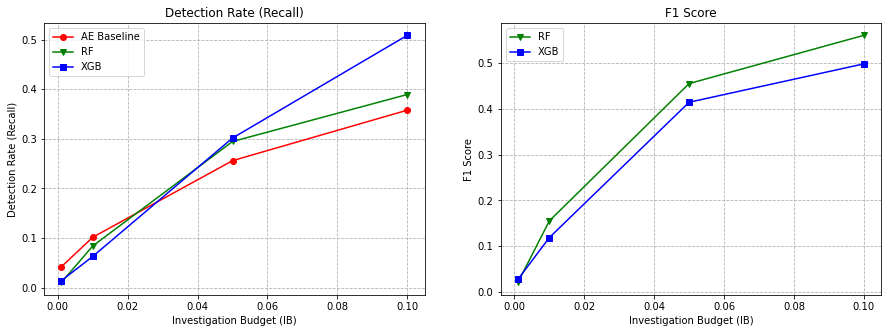

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,5))

plt.subplot(121)
# np.array(AE_baseline_dr)*xTrain.shape[0]/X.shape[0]
plt.plot([0.001, 0.01, 0.05, 0.1], np.array(AE_baseline_dr), color = 'r', label = 'AE Baseline', marker='o')
plt.plot([0.001, 0.01, 0.05, 0.1], RF_pred["recall"], color = 'g', label = 'RF', marker='v')
plt.plot([0.001, 0.01, 0.05, 0.1], XGB_pred["recall"], color = 'b', label = 'XGB', marker='s')

plt.grid(linestyle='--')
plt.legend(loc='upper left')
plt.xlabel('Investigation Budget (IB)')
plt.ylabel('Detection Rate (Recall)')
plt.title('Detection Rate (Recall)')

plt.subplot(122)
plt.plot([0.001, 0.01, 0.05, 0.1], RF_pred["f1-score"], color = 'g', label = 'RF', marker='v')
plt.plot([0.001, 0.01, 0.05, 0.1], XGB_pred["f1-score"], color = 'b', label = 'XGB', marker='s')

plt.grid(linestyle='--')
plt.legend(loc='upper left')
plt.xlabel('Investigation Budget (IB)')
plt.ylabel('F1 Score')
plt.title('F1 Score')

In [ ]:
RF_pred

defaultdict(list,
            {'f1-score': [0.013937282229965157,
              0.13114754098360656,
              0.425414364640884,
              0.5117493472584856],
             'precision': [1.0, 1.0, 1.0, 1.0],
             'recall': [0.007017543859649123,
              0.07017543859649122,
              0.27017543859649124,
              0.34385964912280703],
             'support': [285, 285, 285, 285]})

In [ ]:
XGB_pred

defaultdict(list,
            {'f1-score': [0.013937282229965157,
              0.09966777408637874,
              0.40860215053763443,
              0.4708333333333334],
             'precision': [1.0,
              0.9375,
              0.8735632183908046,
              0.5794871794871795],
             'recall': [0.007017543859649123,
              0.05263157894736842,
              0.26666666666666666,
              0.39649122807017545],
             'support': [285, 285, 285, 285]})